In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'

-rw------- 1 root root 90618980 Mar  9 02:39 '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'


In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip

In [4]:
!ls -l

total 20
drwx------ 5 root root 4096 Apr 11 03:37 drive
drwxr-xr-x 1 root root 4096 Apr  7 13:36 sample_data
drwxr-xr-x 4 root root 4096 Apr 11 03:37 test
drwxr-xr-x 4 root root 4096 Apr 11 03:37 train
drwxr-xr-x 4 root root 4096 Apr 11 03:37 validation


In [5]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'

In [7]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top = False, input_shape=(300,300,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

# feature_Extraction_with_Funtion

In [12]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen =ImageDataGenerator(rescale = 1./255)

batch_size=20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count,9,9,512))
  labels = np.zeros(shape = (sample_count))

  generator = datagen.flow_from_directory(directory, target_size=(300,300), batch_size=batch_size, class_mode='binary')

  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i*batch_size : (i+1)*batch_size] = features_batch
    labels[i*batch_size : (i+1)*batch_size]=labels_batch

    i += 1
    if i * batch_size >= sample_count:
      break

  return features, labels

In [13]:
%%time

train_features, train_labels = extract_features(train_dir, 2000)
valid_features, valid_labels = extract_features(valid_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 43.1 s, sys: 19.8 s, total: 1min 2s
Wall time: 1min 1s


In [14]:
train_features.shape, valid_features.shape, test_features.shape

((2000, 9, 9, 512), (1000, 9, 9, 512), (1000, 9, 9, 512))

In [16]:
train_features = np.reshape(train_features, (2000, 9*9*512))
valid_features = valid_features.reshape(1000, 9*9*512)
test_features = test_features.reshape(1000, 9*9*512)

train_features.shape, valid_features.shape, test_features.shape

((2000, 41472), (1000, 41472), (1000, 41472))

In [19]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=9*9*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               10617088  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 10,617,345
Trainable params: 10,617,345
Non-trainable params: 0
_________________________________________________________________


In [20]:
%%time
Hist = model.fit(train_features, train_labels, epochs=100, batch_size=20, validation_data=(valid_features, valid_labels))

Epoch 1/100
100/100 [==============================] - 1s 9ms/step - loss: 1.3658 - accuracy: 0.6934 - val_loss: 0.3118 - val_accuracy: 0.8610
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.2739 - accuracy: 0.8963 - val_loss: 0.2276 - val_accuracy: 0.9080
Epoch 3/100
100/100 [==============================] - 1s 6ms/step - loss: 0.2196 - accuracy: 0.9085 - val_loss: 0.2310 - val_accuracy: 0.9100
Epoch 4/100
100/100 [==============================] - 1s 6ms/step - loss: 0.1356 - accuracy: 0.9453 - val_loss: 0.2094 - val_accuracy: 0.9140
Epoch 5/100
100/100 [==============================] - 1s 6ms/step - loss: 0.1117 - accuracy: 0.9620 - val_loss: 0.2999 - val_accuracy: 0.8960
Epoch 6/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0986 - accuracy: 0.9631 - val_loss: 0.1896 - val_accuracy: 0.9220
Epoch 7/100
100/100 [==============================] - 1s 6ms/step - loss: 0.1125 - accuracy: 0.9516 - val_loss: 0.2034 - val_accuracy: 0.9200

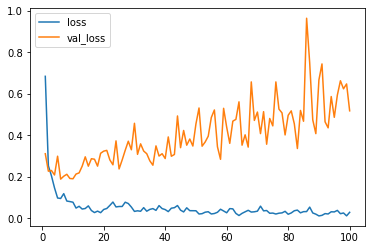

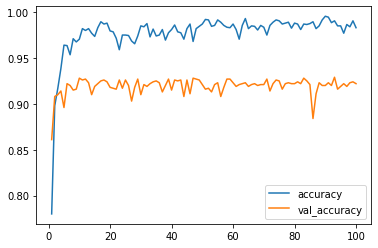

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist.history['loss'])+1)

plt.plot(epochs, Hist.history['loss'])
plt.plot(epochs, Hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

plt.plot(epochs, Hist.history['accuracy'])
plt.plot(epochs, Hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

In [22]:
loss, accuracy = model.evaluate(test_features, test_labels)
loss, accuracy

32/32 [==============================] - 0s 4ms/step - loss: 0.5270 - accuracy: 0.9140


(0.5269824266433716, 0.9139999747276306)

# just concat

In [25]:
from keras import models, layers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               10617088  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 25,332,033
Trainable params: 10,617,345
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
conv_base.trainable = False

print(len(model.trainable_weights))

4


In [28]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(300,300), batch_size=20, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(300,300), batch_size=20, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(300,300), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [29]:
%%time
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Hist = model.fit(train_generator, steps_per_epoch=100, epochs=100, validation_data=valid_generator, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 35s 349ms/step - loss: 1.5502 - accuracy: 0.6776 - val_loss: 0.2626 - val_accuracy: 0.9040
Epoch 2/100
100/100 [==============================] - 33s 327ms/step - loss: 0.2818 - accuracy: 0.8812 - val_loss: 0.2498 - val_accuracy: 0.8930
Epoch 3/100
100/100 [==============================] - 33s 328ms/step - loss: 0.2050 - accuracy: 0.9139 - val_loss: 0.2087 - val_accuracy: 0.9130
Epoch 4/100
100/100 [==============================] - 33s 334ms/step - loss: 0.1644 - accuracy: 0.9319 - val_loss: 0.2567 - val_accuracy: 0.8860
Epoch 5/100
100/100 [==============================] - 33s 329ms/step - loss: 0.1607 - accuracy: 0.9355 - val_loss: 0.1913 - val_accuracy: 0.9190
Epoch 6/100
100/100 [==============================] - 33s 330ms/step - loss: 0.1342 - accuracy: 0.9487 - val_loss: 0.2510 - val_accuracy: 0.9060
Epoch 7/100
100/100 [==============================] - 33s 331ms/step - loss: 0.0945 - accuracy: 0.9629 - val_loss: 0.2232 -

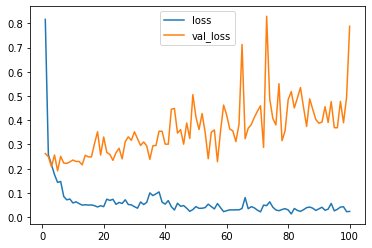

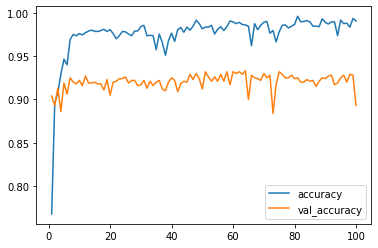

In [30]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist.history['loss'])+1)

plt.plot(epochs, Hist.history['loss'])
plt.plot(epochs, Hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

plt.plot(epochs, Hist.history['accuracy'])
plt.plot(epochs, Hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

In [33]:
loss, accuracy = model.evaluate(test_generator, steps=50)
loss, accuracy

50/50 [==============================] - 11s 223ms/step - loss: 0.8885 - accuracy: 0.8900


(0.8884602189064026, 0.8899999856948853)